In [98]:
import os, sys

os.chdir('e:\Downloads (E)\@Books\@TPM\@PDPC\@data_analysis\model_build')
sys.path.append('e:\Downloads (E)\@Books\@TPM\@PDPC\@data_analysis\model_build')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker as ticker  ## special scaling stuff
import cmasher as cmr
import colorcet as cet
from importlib import reload  ## for reloading packages
import pickle
import OFM_postprocess_scripts as post
from importlib import reload

from matplotlib.ticker import AutoMinorLocator

In [99]:
# retrieve files from saved pickles
model_vers = 'v5.2b'
exps_batchname = 'Policies and Indirect'
exps_filename = f'model{model_vers}_exps_{exps_batchname}_'
exps_s = post.read_experiments_from_pickle(f'data_output/{exps_filename}.pickleobject')
# extract relevant meta-information from pickled experiment object
meta_s = pd.DataFrame.from_dict(exps_s.results_metadata, orient='index')
meta_s['p_FlightBans'] = meta_s['p_FlightBans'].fillna(value=500).astype(int)
meta_s['p_FlightBans_nom'] = meta_s['p_FlightBans'] - exps_s.c_nominal_ref_date
results_s: pd.DataFrame = post.add_extra_metrics(exps_s)

# invert the policy inputs to be relative again (instead of machine-focused)
policy_inputs = dict((v, k) for k, v in exps_s.p_flightbans_map.items())  # inversion process
exps_s.results_verbose = exps_s.results_postprocess = None

## what do I want to do?
for rq1 (without indirect and R) get the difference in days (probably easier to do a different set of experiments)
do figure for difference in timing?
maybe graph in heatmap?

for rq2
make separate graph/heatmap for different R and indirect scenarios
how to show that R has a larger effect? would the heatmap already show that?
could probably drop the effect of direct importation?
need to do searchsort for 10k cases?

In [100]:
daysearch_piv = results_s.pivot(
    values='cum_infected',
    index='elapsed_nominal',
    columns='exp_id',
)
meta_s['days_10k_cumulative'] = daysearch_piv.apply(np.searchsorted, axis=0, v=10000,
                                                    side='left') - exps_s.c_nominal_ref_date



In [101]:
# try groupby
meta_s2 = meta_s.groupby(by='u_Rzero')
mins = meta_s2['days_10k_cumulative'].min()
test = meta_s['u_Rzero'].map(mins)
meta_s['d10k_cumul_vs_null'] = meta_s['days_10k_cumulative'] - test

In [102]:
# sort for alternate plot data without R=1.1
plot_mode = 0

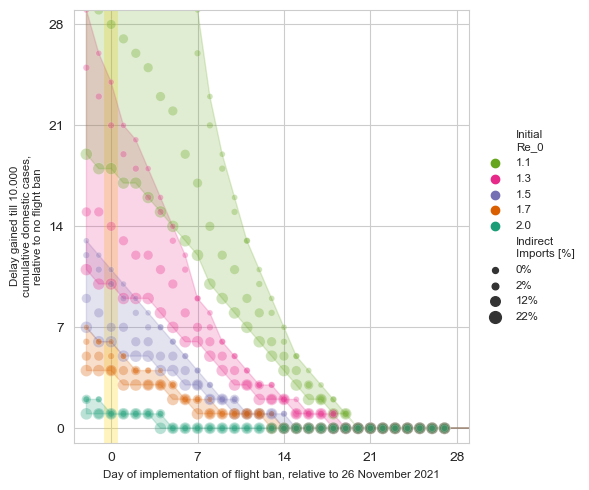

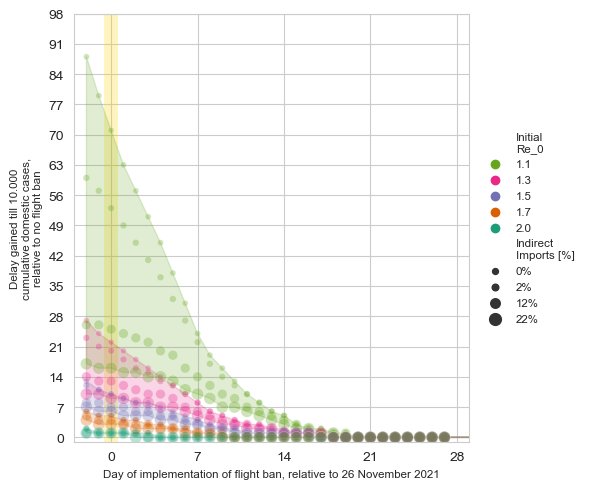

In [103]:
### ScatterPlot creation for RQ2
for plot_mode in [1, 2]:
    fig, ax = plt.subplots(figsize=(6, 5))
    _addon2 = 'manuscript'
    # fig, ax = plt.subplots(figsize=(5.7,2.5))  ## Settings for Jaarcongress post:
    # _addon2 = "jaarcongres"

    # Rzero_order = [1.3, 1.5, 2.0, 2.5]
    ## Section for only specific R numbers and sort for descending Rzero to try and plot the higher R numbers earlier (not useful)
    if plot_mode == 1:  # plot without R= 1.1, yields a more focused graphic
        # plot_data = meta_s[meta_s['u_Rzero'].isin(Rzero_order)].sort_values(by='u_Rzero', ascending=False)
        # plot_data = meta_s[meta_s['u_Rzero'] != 1.1]
        hue_order = [2., 1.7, 1.5, 1.3, 1.1]

    elif plot_mode == 2:  # plot with R=1.1, good as an overview
        plot_data = meta_s
        hue_order = [2., 1.7, 1.5, 1.3, 1.1]

    else:
        raise NotImplementedError(f"plot_mode {plot_mode} not implemented")

    palette = 'Dark2'
    sns.lineplot(data=plot_data,
                 y='d10k_cumul_vs_null',
                 x='p_FlightBans_nom',
                 hue='u_Rzero',
                 hue_order=hue_order,
                 alpha=0.,
                 legend=False,
                 palette=palette,
                 errorbar=('pi', 100),
                 ax=ax)

    sns.scatterplot(data=plot_data,
                    size='u_ImportsIndirect',
                    y='d10k_cumul_vs_null',
                    hue='u_Rzero',
                    hue_order=hue_order,
                    x='p_FlightBans_nom',
                    alpha=0.3,
                    legend='full',
                    palette=palette,
                    ax=ax)

    ## Modify plot legend
    h, l = ax.get_legend_handles_labels()

    # l = ['R','1.3','1.5','2.0','2.5', 'Indirect\nImports [%]', '0%', '10%', '20%', '30%']
    # loc sets anchor, bbox_to_anchor sets location from anchor, frameon eliminates the legend frame
    ## Additional tweaks
    # ax.set_ylabel("Days until 10.000\ncumulative domestic cases", fontsize='small')
    ax.set_ylabel("Delay gained till 10.000\n"
                  "cumulative domestic cases,\n"
                  "relative to no flight ban", fontsize='small')
    ax.set_xlabel("Day of implementation of flight ban, relative to 26 November 2021", fontsize='small')
    # ax.set_title("Effect of starting R number and proportion of indirect imports\non days to 10k cumulative domestic cases")
    ax.axvline(0, c='gold', zorder=0.8, linewidth=10, alpha=0.25)

    ax.set_xlim(-3, 29)
    ax.set_xticks(range(0, 28 + 1, 7))
    if plot_mode == 1:
        save_name_add = "zonder R1.1"
        # ax.set_yticks(range(7,57,7))
        ax.set_yticks(range(0, 30, 7))
        ax.set_ylim(-1, 29)
        # ax.set_xlim(-3, 22)
        # l = ['Initial\nRe_0','1.1','1.3','1.5','1.7','2.0', 'Indirect\nImports [%]', '0%', '2%', '12%', '22%']
        # h_order = [0, 4, 3, 2, 1, 5, 6, 7, 8, 9]  # hard-coding ordering, tedious
    elif plot_mode == 2:
        save_name_add = "met R1.1"
        ax.set_yticks(range(0, 99, 7))
        ax.set_ylim(-1, None)



    else:
        raise NotImplementedError

    l = ['Initial\nRe_0', '1.1', '1.3', '1.5', '1.7', '2.0', 'Indirect\nImports [%]', '0%', '2%', '12%', '22%']
    h_order = [0, 5, 4, 3, 2, 1, 6, 7, 8, 9, 10]  # hard-coding ordering, tedious
    h = [h[hord] for hord in h_order]
    # ax.legend(handles=h, labels=l, loc='upper left',bbox_to_anchor=(1,0.8),frameon=False)
    ax.legend(handles=h, labels=l, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='small')
    # ax.set_xlim(-3, 28)  # Mod for jaarcongress

    # ax.yaxis.set_minor_locator(AutoMinorLocator())  # doesn't work

    save_name = "RQ2,scatter"

    plt.tight_layout()
    plt.savefig(f'output_figures/{model_vers}/{model_vers}_{exps_batchname}_{save_name}_{save_name_add}_{_addon2}.jpg',
                dpi=300)

In [ ]:
m